## Advanced House Price Prediction

- **Applying various machine learning techniques for predicting the house price**

Importing the required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.figure_factory as ff


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import eli5

import keras
from keras import models
from keras import layers

Using TensorFlow backend.


**Loading the datasets from downloaded from kaggle**

In [3]:
home_train_df = pd.read_csv("train.csv")
home_test_df = pd.read_csv("test.csv")
home_test_df['SalePrice'] = 0
home_df = pd.concat([home_train_df, home_test_df], axis=0)
print(home_df.shape)
home_df.head(3)

(2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
### Looking for columns with null values
null_df = pd.DataFrame(home_df.isnull().sum()).reset_index().rename(columns={'index':'Predictors',0:'Count'}).sort_values('Count', ascending=False)
null_df.head()

,Predictors,Count
72,PoolQC,2909
74,MiscFeature,2814
6,Alley,2721
73,Fence,2348
57,FireplaceQu,1420


In [5]:
### Dropping columns with more than 40% null values
null_df['null_percent'] = null_df['Count']/home_df.shape[0]*100
drop_cols = null_df.loc[null_df['null_percent']>40]['Predictors'].tolist()
home_df = home_df.drop(drop_cols, axis=1)
home_df.shape

(2919, 76)

In [6]:
### Found that column with Garage has same null values and for the columns with Basement has same null values 

In [7]:
null_df.loc[null_df['Predictors'].str.startswith(('Garage','Bsmt'))].head(10)

,Predictors,Count,null_percent
60,GarageFinish,159,5.447071
63,GarageQual,159,5.447071
64,GarageCond,159,5.447071
59,GarageYrBlt,159,5.447071
58,GarageType,157,5.378554
32,BsmtExposure,82,2.809181
31,BsmtCond,82,2.809181
30,BsmtQual,81,2.774923
35,BsmtFinType2,80,2.740665
33,BsmtFinType1,79,2.706406


In [8]:
### Garage & Basement columns has same number of null values
gar_bsmt_cols = [col for col in home_df.columns if col.startswith(('Garage','Bsmt'))]
gar_bsmt_df = home_df[gar_bsmt_cols]
print("Number of Garage & Basement columns: {}".format(gar_bsmt_df.shape[-1]))

Number of Garage & Basement columns: 17


In [9]:
bsmt_cols = [col for col in gar_bsmt_df.columns if col.startswith('Bsmt')]
garg_cols = [col for col in gar_bsmt_df.columns if col.startswith('Garage')]

In [10]:
gar_bsmt_df[garg_cols][gar_bsmt_df[garg_cols].isnull().any(axis=1)]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0.0,0.0,NaN,NaN
48,NaN,NaN,NaN,0.0,0.0,NaN,NaN
78,NaN,NaN,NaN,0.0,0.0,NaN,NaN
88,NaN,NaN,NaN,0.0,0.0,NaN,NaN
89,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
1433,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1449,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1453,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1454,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [11]:
gar_bsmt_df[bsmt_cols][gar_bsmt_df[bsmt_cols].isnull().any(axis=1)]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1343,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
1344,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
1364,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
1431,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0


In [12]:
### hence filling "None" for all null values except for "GarageYrBlt" column with "mode"
gar_bsmt_df['GarageYrBlt'].fillna(gar_bsmt_df['GarageYrBlt'].mode(), inplace=True) 
for col in gar_bsmt_df.columns:
    if gar_bsmt_df[col].dtype=='object':
        gar_bsmt_df[col] = gar_bsmt_df[col].fillna('None')
    else:
        gar_bsmt_df[col] = gar_bsmt_df[col].fillna(0)

In [13]:
### Merging home_df and gar_bsmt_df
home_df = home_df[[col for col in home_df.columns if col not in gar_bsmt_df]]
home_df1 = pd.concat([home_df, gar_bsmt_df], axis=1)
home_df1.shape

(2919, 76)

In [14]:
### Looking any remaining null values
null_cols = [col for col in home_df1.columns if home_df1[col].isnull().sum() > 0]
[{col : home_df1[col].isnull().sum()} for col in home_df1.columns if home_df1[col].isnull().sum() > 0]

[{'MSZoning': 4},
 {'LotFrontage': 486},
 {'Utilities': 2},
 {'Exterior1st': 1},
 {'Exterior2nd': 1},
 {'MasVnrType': 24},
 {'MasVnrArea': 23},
 {'TotalBsmtSF': 1},
 {'Electrical': 1},
 {'KitchenQual': 1},
 {'Functional': 2},
 {'SaleType': 1}]

In [15]:
### For float column fill na with median and object columns with mode
for col in null_cols:
    if home_df[col].dtype=='float64':
        home_df1[col] = home_df1[col].fillna(home_df1[col].median(skipna=True))
    else:
        home_df1[col] = home_df1[col].fillna(home_df1[col].mode()[0])

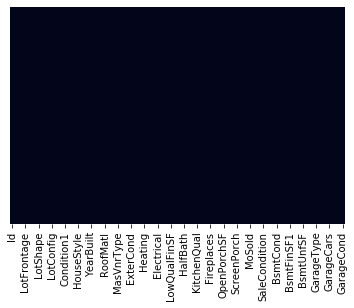

In [16]:
### Looking for null values in the dataset
sns.heatmap(home_df1.isnull(), yticklabels=False, cbar=False)
plt.show()

_Now there are no columns with null values,_ _Need to look for feature engineering_


### Feature Engineering

In [17]:
### Setting "Id" as index column
home_df1 = home_df1.set_index('Id')

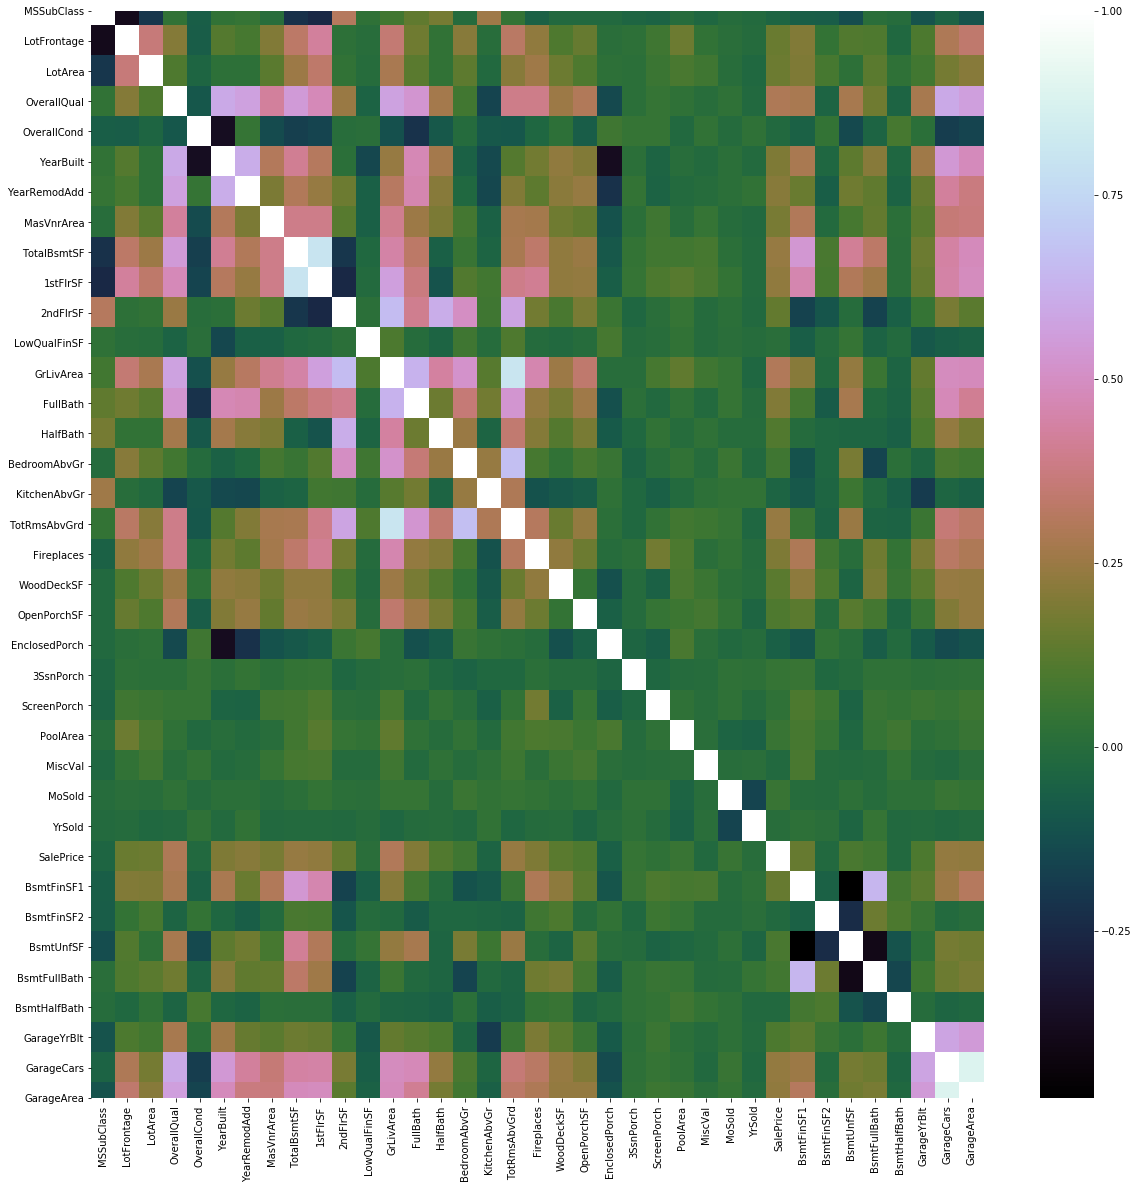

In [18]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
corrmat = home_df1.corr()
sns.heatmap(corrmat, cmap='cubehelix')
plt.show()

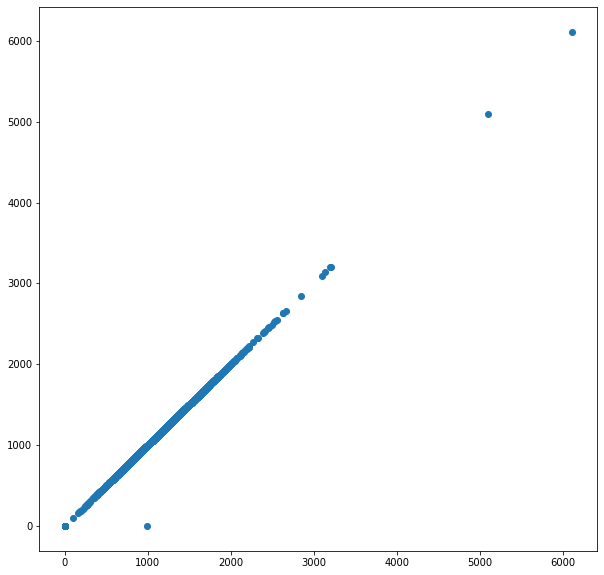

In [19]:
### Checking few correlation of predictors
bsmt_cols = [col for col in home_df1 if "Bsmt" in col]
bsmt_df = home_df1[bsmt_cols]
bsmt_df['cal_bsmt'] = bsmt_df['BsmtFinSF1'] + bsmt_df['BsmtFinSF2'] + bsmt_df['BsmtUnfSF']
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(bsmt_df['TotalBsmtSF'], bsmt_df['cal_bsmt'])
plt.show()

- **From above "TotalBsmt" is aggregated column of "BsmtFinSF1",'BsmtFinSF2' & 'BsmtUnfSF', **
 **Similarly 'GrLivArea' is calculated from '1stFlrSF','2ndFlrSF'& 'LowQualFinSF'**
**hence dropping from the dataframe**

In [20]:
corr_cols = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']
home_df2 = home_df1.drop(corr_cols, axis=1)
home_df2.shape

(2919, 69)

In [21]:
int_cols = [col for col in home_df2.columns if (home_df2[col].dtype == 'float64') | (home_df2[col].dtype == 'int64')]
obj_cols = [col for col in home_df2.columns if (home_df2[col].dtype == 'object')]

In [22]:
home_int = home_df2[int_cols].set_index(home_df2.index)
home_obj = home_df2[obj_cols].set_index(home_df2.index)

In [23]:

for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    home_int[col] = home_int['YrSold'] - home_int[col]

In [24]:
target = home_int['SalePrice'].values
home_int = home_int.drop('SalePrice', axis=1)

In [25]:
### Normalizing the integer columns
scaler = StandardScaler()
scaler.fit(home_int)
stnd_int = scaler.transform(home_int)
stndint_df = pd.DataFrame(stnd_int, columns=home_int.columns, index=home_int.index)
stndint_df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
Id,,,,,,,,,,,,,,,,,,,,,
1,0.067331,-0.191815,-0.217879,0.646183,-0.507284,-1.037881,-0.887009,0.529034,-0.444278,0.413547,...,-0.285935,-0.06315,-0.089592,-1.552184,0.157646,1.087334,-0.249719,-0.294531,0.30704,0.349364
2,-0.873616,0.511940,-0.072044,-0.063185,2.188279,-0.180672,0.357696,-0.567016,0.477158,-0.471891,...,-0.285935,-0.06315,-0.089592,-0.446925,-0.602962,-0.818929,3.822508,-0.236705,0.30704,-0.058991
3,0.067331,-0.051064,0.137197,0.646183,-0.507284,-0.971942,-0.839135,0.338903,-0.299027,0.563755,...,-0.285935,-0.06315,-0.089592,1.026753,0.157646,1.087334,-0.249719,-0.290083,0.30704,0.627787


In [26]:
### One hot encoding categorical values
onehot_df = pd.get_dummies(home_obj, drop_first=True)
onehot_df.head(3)

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [27]:
### Combining both categorical and integer dataframes
home_df3 = pd.concat([stndint_df, onehot_df], axis=1)
home_df3.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,...,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA
Id,,,,,,,,,,,,,,,,,,,,,
1,0.067331,-0.191815,-0.217879,0.646183,-0.507284,-1.037881,-0.887009,0.529034,-0.444278,0.413547,...,0,0,0,0,1,0,0,0,0,1
2,-0.873616,0.511940,-0.072044,-0.063185,2.188279,-0.180672,0.357696,-0.567016,0.477158,-0.471891,...,0,0,0,0,1,0,0,0,0,1
3,0.067331,-0.051064,0.137197,0.646183,-0.507284,-0.971942,-0.839135,0.338903,-0.299027,0.563755,...,0,0,0,0,1,0,0,0,0,1


### Fitting Model

In [28]:
X = home_df3[0:home_train_df.shape[0]]
y = np.log(home_train_df['SalePrice'].values)
final_test = home_df3[home_train_df.shape[0]:]

In [29]:
### Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=626)

In [30]:
### Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.8429973052371135

In [31]:
### Xtreme Gradient Boosting
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.872580057544775

In [32]:
### Gradient Boosting
gbr_model = GradientBoostingRegressor(learning_rate=0.09, loss='lad', criterion='mse')
gbr_model.fit(X_train, y_train)
gbr_model.score(X_test, y_test)

0.8931523807820976

- **Using Grid SearchCV**

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


def best_model_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
                        }
                            },
        'Gradient_Boosting': {
            'model' : GradientBoostingRegressor(),
            'params': {
                'learning_rate': [0.1,0.05,0.01,0.005,0.001],
                'criterion' : ['mse','friedman_mse'],
                'loss' : ['ls', 'lad', 'huber']
                        }
                            },
        'Xtreme_Gradient_Boosting': {
            'model': XGBRegressor(),
            'params': {
                'max_depth': range (2, 10, 1),
                'learning_rate': [0.1,0.05,0.01,0.005,0.001],
                'n_estimators': range(60, 220, 40)
                        }
                                    },
        'Random_Forest' : {
            'model': RandomForestRegressor(),
            'params': {
                'bootstrap': ['True'],
                'max_depth': [5, 10, None], 
                'max_features': ['auto', 'log2'], 
                'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
                        }
                            }
            }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=626)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

best_model = best_model_gridsearchcv(X, y)
best_model

,model,best_score,best_params
0,linear_regression,-1.403401e+22,{'normalize': False}
1,Gradient_Boosting,8.873602e-01,"{'criterion': 'mse', 'learning_rate': 0.1, 'lo..."
2,Xtreme_Gradient_Boosting,8.916201e-01,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
3,Random_Forest,8.586778e-01,"{'bootstrap': 'True', 'max_depth': None, 'max_..."


In [34]:
best_model.loc[best_model['model']=='Xtreme_Gradient_Boosting']['best_params'].values

array([{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 180}],
      dtype=object)

- Applying with best paramters

In [35]:
results=[]
names=[]

num_folds = 5
seed = 626
scoring='r2'

In [36]:
xgb_model = XGBRegressor(learning_rate= 0.1, max_depth= 4, n_estimators= 180)
kfold = KFold(n_splits=num_folds, random_state=seed)
cv_results = cross_val_score(xgb_model, X, y, cv=kfold, scoring=scoring)
print(cv_results.mean())
cv_results

0.8925065733941171


array([0.90697945, 0.87887445, 0.88961054, 0.90212415, 0.88494428])

In [38]:
xgb_model.fit(X, y)
predictions = xgb_model.predict(final_test)
exp_preds = np.exp(predictions)
pd.DataFrame(exp_preds).to_csv('predictions.csv')